reference - [https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/building-a-facial-recognition-model-using-pca-svm-algorithms-c81d870add16](https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/building-a-facial-recognition-model-using-pca-svm-algorithms-c81d870add16)

In [35]:
import pylab as pl
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mplib 
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

In [95]:
data_path = 'dataset/CK+48'
data_dir_list = os.listdir(data_path)

img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img = cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        img_data_list.append(input_img)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255

n_samples, h, w = img_data.shape
np.random.seed(42)

img_data = img_data.reshape(n_samples,-1)

img_data.shape

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



(327, 2304)

In [96]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:45]=0      #45
labels[46:63]=1     #18
labels[64:122]=2    #59
labels[123:147]=3   #25
labels[148:216]=4   #69
labels[217:244]=5   #28
labels[245:327]=6   #83

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

n_classes = len(names)

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

In [104]:
Y = np_utils.to_categorical(labels, num_classes)
y = labels
X_train, X_test, y_train, y_test = train_test_split(img_data, y, test_size=0.30, shuffle=True, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((228, 2304), (228,), (99, 2304), (99,))

In [105]:
n_components = 50
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
sum(pca.explained_variance_ratio_)

0.9177155538927764

In [106]:
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenfaces.shape

(50, 48, 48)

In [107]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((228, 50), (99, 50))

In [108]:
print("Fitting the classifier to the training set")
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [109]:
print("Predicting the people names on the testing set")
y_pred = clf.predict(X_test_pca)

Predicting the people names on the testing set


In [110]:
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       0.50      0.79      0.61        14
    contempt       0.50      0.33      0.40         9
     disgust       0.68      0.68      0.68        19
        fear       0.86      0.75      0.80         8
       happy       0.95      1.00      0.97        19
     sadness       0.17      0.14      0.15         7
    surprise       0.95      0.78      0.86        23

    accuracy                           0.72        99
   macro avg       0.66      0.64      0.64        99
weighted avg       0.73      0.72      0.72        99



In [113]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[11  1  1  0  0  1  0]
 [ 2  3  1  1  0  1  1]
 [ 3  0 13  0  1  2  0]
 [ 1  1  0  6  0  0  0]
 [ 0  0  0  0 19  0  0]
 [ 4  1  1  0  0  1  0]
 [ 1  0  3  0  0  1 18]]


In [115]:
def title(y_pred, y_test, target_names, i):
    pred_name = names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue: %s' % (pred_name, true_name)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

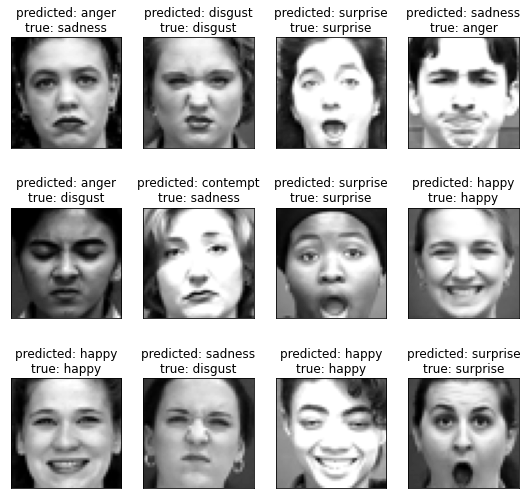

In [116]:
prediction_titles = [title(y_pred, y_test, names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

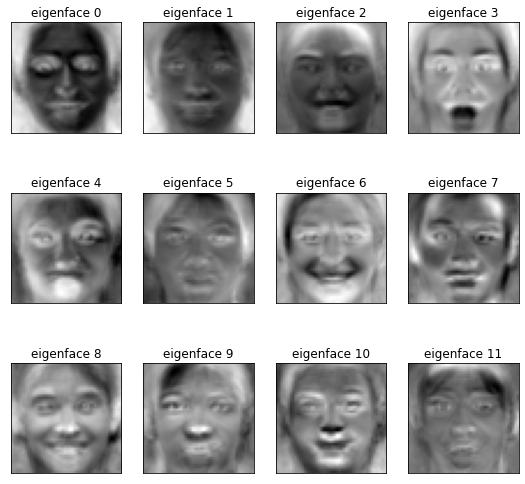

In [117]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [118]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(score)

0.7171717171717171
